### 1. CPU 및 GPU 환경설정

In [ ]:
import torch
import torch
import random
import numpy as np
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

### 2. 데이터셋

### NAVER NLP Challenge 2018 NER 데이터셋

In [ ]:
!pip install korpora

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
from Korpora import Korpora
corpus = Korpora.load("naver_changwon_ner")


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : 네이버 + 창원대
    Repository : https://github.com/naver/nlp-challenge/tree/master/missions/ner
    References : http://air.changwon.ac.kr/?page_id=10

    개체명(Named Entity)은 인명, 기관명, 지명 등과 같이 문장 또는 문서에서 특정한 의미를 가지고 있는 단어 또는 어구를 말합니다.
    이 때문에 개체명은 정보 검색 및 언어 이해를 위한 분석에서 주요한 대상으로 다루어지고 있습니다.
    Data.ly에서는 개체명 코퍼스를 제공하여 연구에 도움을 드리고자 하며, 공개적인 리더보드를 통해 많은 분들의 연구 동향을 논의/공유하고자 합니다.
    제공되는 코퍼스는 Data.ly에서 제작한 것으로, 연구 및 리더보드를 위한 학습으로 사용 가능하며 상업적인 목적으로 사용될 수 없습니다.

    # License
    연구 및 리더보드를 위한 학습으로 사용 가능하며 상업적인 목적으로 사용될 수 없습니다.

[Korpora] Corpus `naver_changwon_ner` is already installed at /root/Korpora/naver_changwon_ner/train_data


### 3. 허깅페이스 트랜스포머 설치

In [ ]:
!pip install transformers==4.5.1

  Using cached transformers-4.5.1-py3-none-any.whl (2.1 MB)
  Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects


### 4. 데이터셋 샘플

In [9]:
#네이버 NER 챌린지 데이터셋
corpus.train[0]

WordTag(text='비토리오 양일 만에 영사관 감호 용퇴, 항룡 압력설 의심만 가율 ', words=['비토리오', '양일', '만에', '영사관', '감호', '용퇴,', '항룡', '압력설', '의심만', '가율'], tags=['PER_B', 'DAT_B', '-', 'ORG_B', 'CVL_B', '-', '-', '-', '-', '-'])

In [ ]:
len(corpus.train)

90000

In [ ]:
num_tags = sum(len(data.tags) for data in corpus.train)
num_tags

1063571

### 5. CVL tag로 부터 법 관련 단어들을 필터링하여 LAW tag 생성

In [ ]:
# Get the unique tag types in corpus.train
unique_tag_types = set(tag for data in corpus.train for tag in data.tags)

# Print the number of unique tag types
num_unique_tag_types = len(unique_tag_types)
print(f"Number of unique tag types in corpus.train: {num_unique_tag_types}")

# Print the unique tag types
print("Unique tag types:", unique_tag_types)

Number of unique tag types in corpus.train: 29
Unique tag types: {'MAT_I', 'AFW_I', 'DAT_B', 'FLD_B', 'LOC_I', '-', 'MAT_B', 'ANM_B', 'TIM_B', 'EVT_I', 'LOC_B', 'NUM_I', 'ANM_I', 'PLT_I', 'EVT_B', 'PER_I', 'DAT_I', 'TRM_I', 'ORG_B', 'PER_B', 'TIM_I', 'CVL_I', 'PLT_B', 'NUM_B', 'ORG_I', 'CVL_B', 'AFW_B', 'FLD_I', 'TRM_B'}


In [ ]:
from collections import Counter

# Create a Counter for tag types
tag_counts = Counter(tag for data in corpus.train for tag in data.tags)

# Print the number of words corresponding to each unique tag type
for tag, count in tag_counts.items():
    print(f"Tag: {tag}, Number of Words: {count}")

Tag: PER_B, Number of Words: 43034
Tag: DAT_B, Number of Words: 25837
Tag: -, Number of Words: 729659
Tag: ORG_B, Number of Words: 40860
Tag: CVL_B, Number of Words: 57502
Tag: NUM_B, Number of Words: 56136
Tag: LOC_B, Number of Words: 20881
Tag: EVT_B, Number of Words: 10982
Tag: TRM_B, Number of Words: 18695
Tag: TRM_I, Number of Words: 3375
Tag: EVT_I, Number of Words: 6448
Tag: PER_I, Number of Words: 5165
Tag: CVL_I, Number of Words: 3416
Tag: NUM_I, Number of Words: 8740
Tag: TIM_B, Number of Words: 3263
Tag: TIM_I, Number of Words: 1074
Tag: ANM_B, Number of Words: 6486
Tag: DAT_I, Number of Words: 8107
Tag: FLD_B, Number of Words: 2345
Tag: ORG_I, Number of Words: 4668
Tag: MAT_B, Number of Words: 238
Tag: MAT_I, Number of Words: 14
Tag: AFW_B, Number of Words: 4247
Tag: LOC_I, Number of Words: 211
Tag: AFW_I, Number of Words: 1822
Tag: PLT_B, Number of Words: 264
Tag: FLD_I, Number of Words: 41
Tag: ANM_I, Number of Words: 58
Tag: PLT_I, Number of Words: 3


In [10]:
# Extract data with tags containing 'CVL'
cvl_data = [data for data in corpus.train if any('CVL' in tag for tag in data.tags)]

# Print CVL data
for data in cvl_data[:3]:
    print(f"Text: {data.text}")
    print(f"Tags: {data.tags}")
    print("-" * 30)

Text: 비토리오 양일 만에 영사관 감호 용퇴, 항룡 압력설 의심만 가율 
Tags: ['PER_B', 'DAT_B', '-', 'ORG_B', 'CVL_B', '-', '-', '-', '-', '-']
------------------------------
Text: ▲ 퍼거슨 씨족의 꾀 
Tags: ['-', 'PER_B', 'CVL_B', '-']
------------------------------
Text: [유로2008] '공인구가 변할 기록 시정조치는 죽을 맛 ? ' 
Tags: ['EVT_B', 'CVL_B', '-', '-', 'CVL_B', '-', '-', '-', '-']
------------------------------


In [11]:
# Extract words with tags 'CVL_B' or 'CVL_I'
cvl_words = []
for data in corpus.train:
    for word, tag in zip(data.words, data.tags):
        if tag in ['CVL_B', 'CVL_I']:
            cvl_words.append(word)

# # Print CVL words
# print(" ".join(cvl_words))

In [12]:
len(cvl_words)

60918

In [13]:
# Extract words containing 'law'
law_words = [word for word in cvl_words if '법' in word.lower()]

# Print the list of words containing 'law'
print(law_words) # 972개

['지방자치법,', '미디어법', '법제도가', '디도스특검법', '유통산업발전법', '불법콘텐츠]', '법률고문은', '불법대출,', '의무신고제법', '방송법의', '국가공무원법은', '법관윤리강령', '국가계약법', '법원조직법의', 'LBS법', '정당법', '입법위원이', '노동법', '정부조직법', '제주특별법', '국가인권위원회법', '불법복제가', '제주특별법', '국민투표법', '도시개발법', '금융소비자보호법들이', '소년법은', '신문법들에게는', '소년법은', '형사법형사특별법의', '헌법개정안', '법사위원장이', '응급의료법', '명예훼손법이라는', '개항질서법한', '우마변상법은', '법의학자', '마법사]', '이자제한법', '청원경찰법', '통신비밀보호법', '쌍둥이법이', '민사집행법이', '정부조직법이', '법사위원장을', '경제법', '무법자의', '석유사업법보다', '불법체류자가', '헌법개정안', '이자제한법계', '법안을', '제헌헌법에', '특검법은', '변호사법을', '사학법', '보안법이', '특검법', '개발법', '상생법을', '철우언론법상', '신문법으로', '미디어레법', '법률부위원장의', '치매관리법을', '의료법', '입법권,', '법관윤리강령', '사법피해자', '형법은', '법무팀장은', '교통사고처리특례법]', '조세특례제한법의', '불법도청들의', '미디어악법', '석면안전관리법', '미디어관련법', '불법도청의', '사면법은', '법무사들의', '방송법은', '사학법은', '방송사업법생', '특별조치법의', '의료급여법,', '제헌헌법인', '사법경찰관', '인사청문회법', '항법사들이', '구걸금지법', '나경원법에게', '병역법', '공직선거법이', '유통산업발전법', '짐크로법', '금융실명제법', '헌법학자는', '법안은', '미디어법이', '법원조직법님', '부르카금지법은', '국가보안법', '법인장들을', '조세법은', '국민건강보험법했다', '헌법개정안', '新저작권법](중)비친고

In [14]:
len(law_words)

972

In [15]:
filtered_law_words = [word for word in cvl_words if word.lower().endswith('법') or
                      (len(word) > 1 and word.lower()[-2] == '법') or
                      (len(word) > 2 and word.lower()[-3] == '법')]
print(len(filtered_law_words)) # 723개

723


In [16]:
filtered_law_words[:8]

['지방자치법,', '미디어법', '디도스특검법', '유통산업발전법', '의무신고제법', '방송법의', '국가공무원법은', '국가계약법']

In [17]:
# Find indices of words corresponding to 'filtered_law_words'
indices_to_change = [i for i, word in enumerate(cvl_words) if word in filtered_law_words]

In [18]:
len(indices_to_change)

723

In [19]:
# Iterate through all entries in the training set
for data in corpus.train:
    # Find indices of words belonging to 'filtered_law_words' for each entry
    indices_to_change = [i for i, words in enumerate(data.words) if any(word in words for word in filtered_law_words)]

    # Change the tags of corresponding words to 'LAW'
    for index in indices_to_change:
        data.tags[index] = 'LAW'

In [20]:
from collections import Counter

# Create a Counter for tag types
tag_counts = Counter(tag for data in corpus.train for tag in data.tags)

# Print the number of words corresponding to each unique tag type
for tag, count in tag_counts.items():
    print(f"Tag: {tag}, Number of Words: {count}")

Tag: PER_B, Number of Words: 43016
Tag: DAT_B, Number of Words: 25834
Tag: -, Number of Words: 727902
Tag: ORG_B, Number of Words: 40668
Tag: CVL_B, Number of Words: 56592
Tag: NUM_B, Number of Words: 56128
Tag: LOC_B, Number of Words: 20853
Tag: EVT_B, Number of Words: 10977
Tag: TRM_B, Number of Words: 18674
Tag: TRM_I, Number of Words: 3355
Tag: EVT_I, Number of Words: 6405
Tag: PER_I, Number of Words: 5162
Tag: CVL_I, Number of Words: 3354
Tag: NUM_I, Number of Words: 8719
Tag: TIM_B, Number of Words: 3263
Tag: TIM_I, Number of Words: 1074
Tag: ANM_B, Number of Words: 6486
Tag: DAT_I, Number of Words: 8106
Tag: FLD_B, Number of Words: 2320
Tag: ORG_I, Number of Words: 4643
Tag: LAW, Number of Words: 3153
Tag: MAT_B, Number of Words: 238
Tag: MAT_I, Number of Words: 14
Tag: AFW_B, Number of Words: 4245
Tag: LOC_I, Number of Words: 211
Tag: AFW_I, Number of Words: 1813
Tag: PLT_B, Number of Words: 264
Tag: FLD_I, Number of Words: 41
Tag: ANM_I, Number of Words: 58
Tag: PLT_I, Number 

### 6. 데이터셋 전처리

- 뉴스 기사 내에서 법 관련 단어들만 뽑아내고 싶기 때문에 LAW tag 만 뽑아내기 위해 데이터셋 전처리 진행 </br>
- law_url data에서 랜덤 법률안 이름을 데이터셋내 LAW와 대체하여 뉴스 기사 내에서 법 관련 단어들을 더 잘 뽑아내도록 학습시킴

In [21]:
#구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
cd /content/drive/MyDrive/BITAmin_final_project/

/content/drive/MyDrive/BITAmin_final_project


In [23]:
ls

 03_transformer-anatomy.ipynb  'legislation_keybert.ipynb의 사본'
 data/                          legislation_keyword.ipynb
 honeybee-main/                 logs/
 issue_detection.ipynb          output/
 KCELECTRA_NER_기남.ipynb       similarity.ipynb
 KCELECTRA_NER_원본.ipynb       summarizing_by_Prompt_Engineering.ipynb
 KoBERTopic.ipynb               TextSummarization.ipynb
 legislation_issue.ipynb        Untitled0.ipynb
 legislation_keybert.ipynb


In [24]:
import pandas as pd
df = pd.read_csv('data/law_url.csv')

In [25]:
df.head()

,title,url,category
0,헌법재판소 사무기구에 관한 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법
1,헌법재판소 공무원 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법
2,헌법재판소 공무원 평정 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법
3,공직자윤리법의 시행에 관한 헌법재판소 규칙,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법
4,평화경제특별구역의 지정 및 운영에 관한 법률 시행령,https://likms.assembly.go.kr/law/lawsLawtInqyD...,헌 법


In [26]:
def extract_last_two_chars(text):
    return text[-2:]

# Apply the function to create a new column 'last2'
df['last2'] = df['title'].apply(extract_last_two_chars)

In [27]:
def extract_last_one_char(text):
    return text[-1:]

# Apply the function to create a new column 'last2'
df['last1'] = df['title'].apply(extract_last_one_char)

In [28]:
df['last2'].value_counts()

규칙    2117
행령    1461
법률     703
규정     636
별법     151
      ... 
기령       1
제령       1
위법       1
망법       1
6호       1
Name: last2, Length: 186, dtype: int64

In [29]:
df['last1'].value_counts()

칙    2138
령    1805
법    1102
률     703
정     636
건     106
제     103
호      11
준       4
치       2
위       1
범       1
안       1
역       1
례       1
서       1
식       1
장       1
금       1
기       1
Name: last1, dtype: int64

In [30]:
df_법률 = df[(df['last1']=='법') | (df['last1']=='률')]

In [31]:
len(df_법률)

1805

In [32]:
len(df_법률['title'].unique())

1784

In [33]:
unique_law = df_법률['title'].unique()
unique_law

array(['평화경제특별구역의 지정 및 운영에 관한 법률', '개성공업지구 지원에 관한 법률', '남북협력기금법', ...,
       '인허가등의정비를위한행정서사법등의일부개정법률', '비상국무회의법', '물품세법등중개정법률'], dtype=object)

In [34]:
unique_law_list = unique_law.tolist() # 1784개

In [35]:
unique_law_list[:3]

['평화경제특별구역의 지정 및 운영에 관한 법률', '개성공업지구 지원에 관한 법률', '남북협력기금법']

In [119]:
# Count the number of strings without spaces # 공백없는 문자열의 개수 : 707 / 전체 : 1784
count_without_spaces = sum(1 for law in unique_law_list if ' ' not in law)

# Print the result
print("Number of strings without spaces:", count_without_spaces)

Number of strings without spaces: 707


In [116]:
unique_law_list_no_spaces = [law.replace(' ', '') for law in unique_law_list]
unique_law_list_no_spaces[:4]

['평화경제특별구역의지정및운영에관한법률', '개성공업지구지원에관한법률', '남북협력기금법', '민주평화통일자문회의법']

In [ ]:
unique_law_list_no_spaces = [law.replace(' ', '') for law in unique_law_list]

# Count the number of strings without spaces
num_strings_without_spaces = len(unique_law_list_no_spaces)

# Print the result
print("Number of strings without spaces:", num_strings_without_spaces)

#### 네이버 데이터셋 전처리

In [36]:
def naver_read_file(file_list):


    token_docs = []
    tag_docs = []

    for doc in file_list:
        tokens = []
        tags = []
        list1=doc.words
        list2=doc.tags



        for text,docs in zip(list1,list2):
            try:
                tag = docs

                    # 2: pos, 3: ner
                if tag in ['LAW']:
                    if tag == 'LAW':
                        token = random.sample(unique_law_list, k=1)[0] #tag가 LAW이면 목록의 법령명 중 하나로 랜덤으로 대체
                    else:
                        token = text
                else:
                    token = text
                    tag = 'O'
                for i, syllable in enumerate(token): # 음절 단위로 자르고
                    tokens.append(syllable)
                    modi_tag = tag
                    if i > 0:
                        if tag[0] == 'B':
                            modi_tag = 'I' + tag[1:]     # BIO tag를 부착
                    tags.append(modi_tag)
            except:
                continue
        token_docs.append(tokens)
        tag_docs.append(tags)

    return token_docs, tag_docs

In [37]:
naver_text,naver_tags =naver_read_file(corpus.train)

In [38]:
print(len(naver_text))
print(len(naver_tags))

90000
90000


In [39]:
print(naver_text[77], end='\n\n')
print(naver_tags[77])

['앵', '커', ':', '이', '광', '석', '성', '국', '회', '부', '의', '장', '이', '6', '·', '2', '5', ' ', '전', '사', '자', '유', '해', '의', ' ', '발', '굴', ' ', '등', '에', ' ', '관', '한', ' ', '법', '률', '직', '권', '상', '정', '을', '했', '고', '의', '결', '을', '개', '시', '하', '겠', '다', '고', '포', '고', '를', '했', '습', '니', '다', '.']

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'LAW', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [40]:
# Find indices of text containing 'LAW' in the tags
indices_with_law = [i for i, data in enumerate(corpus.train) if any(tag == 'LAW' for tag in data.tags)]

In [41]:
len(indices_with_law)

2947

In [42]:
indices_with_law[:10]

[38, 39, 40, 77, 87, 101, 145, 180, 208, 229]

In [43]:
corpus.train[77]

WordTag(text='앵커: 이광석성 국회부의장이 미디어법 직권상정을 했고 의결을 개시하겠다고 포고를 했습니다 . ', words=['앵커:', '이광석성', '국회부의장이', '미디어법', '직권상정을', '했고', '의결을', '개시하겠다고', '포고를', '했습니다', '.'], tags=['CVL_B', 'PER_B', 'CVL_B', 'LAW', '-', '-', '-', '-', '-', '-', '-'])

In [45]:
texts = naver_text
tags = naver_tags

In [46]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [47]:
for i, tag in enumerate(unique_tags):
    print(tag)  # 학습을 위한 label list를 확인합니다.

LAW
O


### 7. EDA

In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
texts_len = [len(x) for x in texts]

Text(0, 0.5, 'Probability')

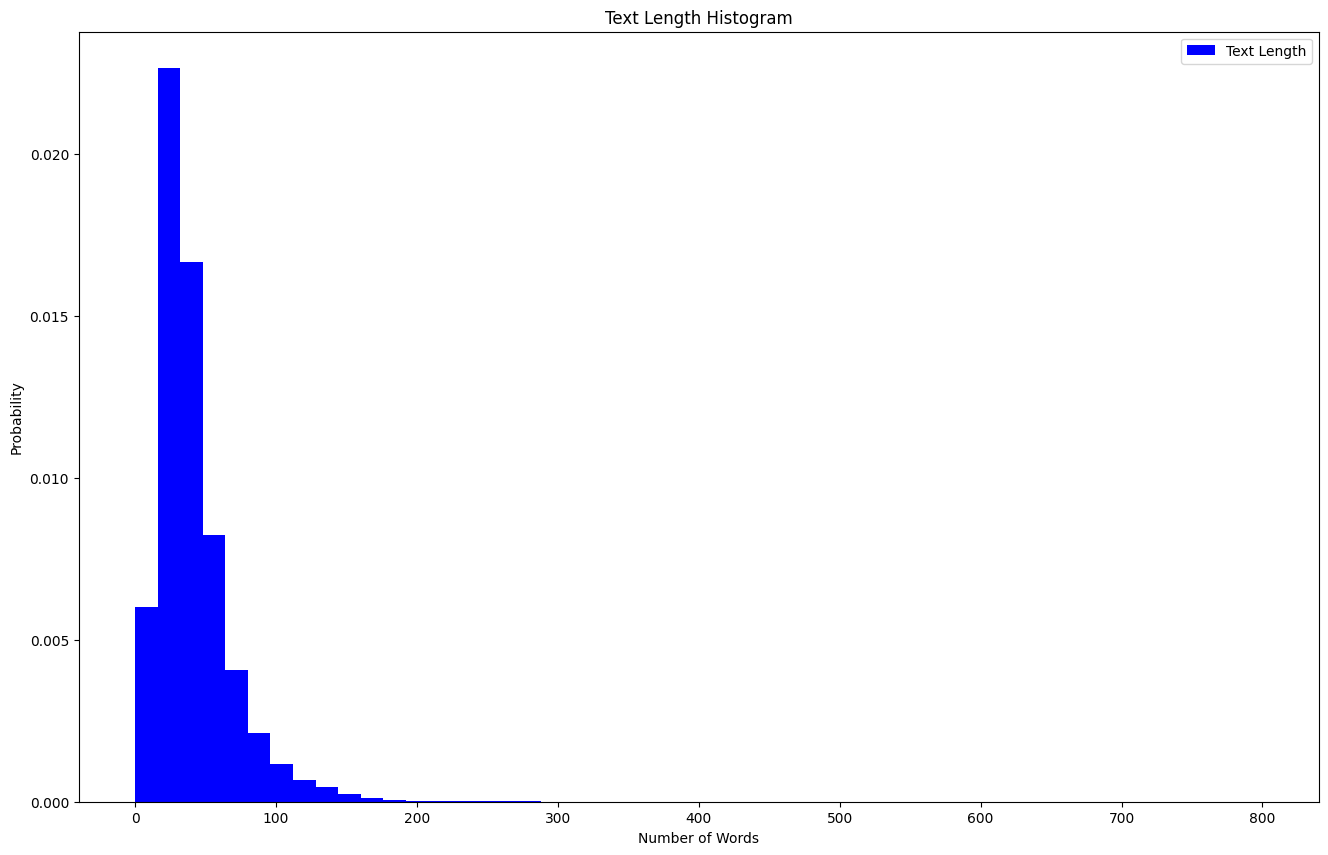

In [50]:
plt.figure(figsize=(16,10))
plt.hist(texts_len, bins=50, range=[0,800], facecolor='b', density=True, label='Text Length')
plt.title('Text Length Histogram')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Probability')

In [51]:
for tag in list(tag2id.keys()) :
    globals()[tag] = 0

In [52]:
for tag in tags :
    for ner in tag :
        globals()[ner] += 1

In [53]:
for tag in list(tag2id.keys()) :
    print('{:>6} : {:>7,}'. format(tag, globals()[tag]))

   LAW :  48,305
     O : 3,592,723


In [54]:
# for tag in list(tag2id.keys()) :
#     print('{:>6} : {:>7,}'. format(tag, globals()[tag]))

### 8. Train Test Split

In [55]:
# Total number of elements
total_elements = 90000

# Initialize one-hot encoding list with all zeros
one_hot_encoding = [0] * total_elements

# Set specified indices to 1
for index in indices_with_law:
    one_hot_encoding[index] = 1

print(one_hot_encoding[:50])
print(len(one_hot_encoding))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
90000


In [56]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_tags, test_tags = train_test_split(texts, tags, test_size=.2, stratify=one_hot_encoding, random_state=42)

In [57]:
print('Train 문장 : {:>6,}' .format(len(train_texts)))
print('Train 태그 : {:>6,}' .format(len(train_tags)))
print('Test  문장 : {:>6,}' .format(len(test_texts)))
print('Test  태그 : {:>6,}' .format(len(test_tags)))

Train 문장 : 72,000
Train 태그 : 72,000
Test  문장 : 18,000
Test  태그 : 18,000


### 9. BERT 토크나이저


In [58]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [59]:
unique_tags = set(tag for doc in tags for tag in doc)
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [60]:
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

In [61]:
# 기존 토크나이저는 wordPiece tokenizer로 tokenizing 결과를 반환합니다.
# 데이터 단위를 음절 단위로 변경했기 때문에, tokenizer도 음절 tokenizer로 바꿔줘야함

# berttokenizer를 쓸건데 여기에 들어있는 8000개 밖에 안되는 한국어가 들어있지만 많은수가 음절이다.
# 한국어들의 거의 음절로 존재. -> 음절 단위 tokenizer를 적용해도 vocab id를 어느 정도 획득할 수 있음.
# 그래서 음절로 쪼개면 UNK가 별로 없을 것이다.

def ner_tokenizer(sent, max_seq_length):
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # 중간 음절에는 모두 prefix를 붙입니다.
            # 우리가 구성한 학습 데이터도 이렇게 구성되었기 때문이라고 함.
            # 이순신은 조선 -> [이, ##순, ##신, ##은, 조, ##선]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1

    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [62]:
train_texts[0]

['그',
 '는',
 '맨',
 '유',
 '에',
 '귀',
 '중',
 '한',
 '본',
 '체',
 '”',
 '라',
 '고',
 '강',
 '조',
 '했',
 '다',
 '.']

In [63]:
print(ner_tokenizer(train_texts[0], 5))
# 'token_type_ids': [0, 0, 0, 0, 0] 은 segmentA로 0000으로 되어있는거.

{'input_ids': [2, 1022, 4027, 4607, 3], 'attention_mask': [1, 1, 1, 1, 1], 'token_type_ids': [0, 0, 0, 0, 0]}


In [64]:
tokenized_train_sentences = []
tokenized_test_sentences = []

for text in train_texts:    # 전체 데이터를 tokenizing 합니다.
    tokenized_train_sentences.append(ner_tokenizer(text, 128))
for text in test_texts:
    tokenized_test_sentences.append(ner_tokenizer(text, 128))

In [65]:
# 우리의 label도 truncation과 tokenizing이 필요하다.
def encode_tags(tags, max_seq_length):
    # label 역시 입력 token과 개수를 맞춰줍니다
    tags = tags[:max_seq_length-2]
    labels = [tag2id[tag] for tag in tags]
    labels = [tag2id['O']] + labels

    padding_length = max_seq_length - len(labels)
    labels = labels + ([pad_token_label_id] * padding_length)

    return labels

In [66]:
tag2id

{'LAW': 0, 'O': 1}

In [67]:
encode_tags(train_tags[0], 5)

[1, 1, 1, 1, 1]

In [68]:
train_labels = []
test_labels = []

for tag in train_tags:
    train_labels.append(encode_tags(tag, 128))

for tag in test_tags:
    test_labels.append(encode_tags(tag, 128))

In [69]:
len(train_labels), len(test_labels)

(72000, 18000)

### 10. Token 데이터셋

In [70]:
import torch

class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val) for key, val in self.encodings[idx].items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TokenDataset(tokenized_train_sentences, train_labels)
test_dataset = TokenDataset(tokenized_test_sentences, test_labels)

In [80]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 7.0 MB/s eta 0:00:00


In [82]:
!pip show accelerate

Name: accelerate
Version: 0.26.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [95]:
!curl --proto '=https' --tlsv1.2 -sSf https://sh.rustup.rs | sh

info: downloading installer
sh: 172: cannot open /dev/tty: No such device or address


In [71]:
!pip show transformers

Name: transformers
Version: 4.37.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [101]:
!pip install transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [72]:
# BertForSencenceClassification이 아니다! token이 목적이다.
from transformers import BertForTokenClassification, Trainer, TrainingArguments, AutoModelForTokenClassification,EarlyStoppingCallback
import sys

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/BITAmin_final_project/output',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1000, # 1000번쨰 steps마다 log를 보여줌
    learning_rate=3e-5,
    weight_decay=0.01,
    save_total_limit=5,
    save_strategy='steps', # steps로 해야 earlystop이 가능
    evaluation_strategy='steps',
    save_steps=1000, # 1000번쨰 step마다 저장
    eval_steps=1000, # 1000번째 step마다 평가
    seed=15,
    load_best_model_at_end=True # 가장 좋은 성능의 모델로...
)

### 11. BertForTokenClassification (모델 학습 및 성능 확인)

In [73]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, num_labels=len(unique_tags))
model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,# evaluation dataset
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)] #loss가 2번 감소하지 않으면 스탑
)

pytorch_model.bin:   0%|          | 0.00/511M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
import gc
gc.collect()

107

In [ ]:
# import gc
# gc.collect()

5134

In [75]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.009200,0.001593
2000,0.002100,0.001605
3000,0.002100,0.001263
4000,0.001200,0.001711
5000,0.001100,0.001101
6000,0.001200,0.000946
7000,0.001200,0.000986
8000,0.001000,0.000753
9000,0.000800,0.000866
10000,0.000500,0.000925


TrainOutput(global_step=10000, training_loss=0.002033005356788635, metrics={'train_runtime': 3778.3379, 'train_samples_per_second': 57.168, 'train_steps_per_second': 7.146, 'total_flos': 5225935134720000.0, 'train_loss': 0.002033005356788635, 'epoch': 1.11})

In [76]:
trainer.evaluate()

{'eval_loss': 0.0007525839027948678,
 'eval_runtime': 140.4447,
 'eval_samples_per_second': 128.164,
 'eval_steps_per_second': 2.008,
 'epoch': 1.11}

In [77]:
predictions = trainer.predict(test_dataset)
print(predictions.predictions.shape, predictions.label_ids.shape)

(18000, 128, 2) (18000, 128)


In [ ]:
# predictions = trainer.predict(test_dataset)
# print(predictions.predictions.shape, predictions.label_ids.shape)

(21853, 128, 3) (21853, 128)


In [78]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [79]:
index_to_ner = {i:j for j, i in tag2id.items()}
f_label = [i for i, j in tag2id.items()]
val_tags_l = [index_to_ner[x] for x in np.ravel(predictions.label_ids).astype(int).tolist()]
y_predicted_l = [index_to_ner[x] for x in np.ravel(preds).astype(int).tolist()]

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [81]:
#데이터셋 추가
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

         LAW       0.97      0.97      0.97      9184
           O       1.00      1.00      1.00   2294816

    accuracy                           1.00   2304000
   macro avg       0.98      0.98      0.98   2304000
weighted avg       1.00      1.00      1.00   2304000



In [ ]:
#이전
print(classification_report(val_tags_l, y_predicted_l, labels=f_label))

              precision    recall  f1-score   support

       B-PER       0.98      1.00      0.99     11529
           O       1.00      1.00      1.00   2762775
       I-PER       0.98      1.00      0.99     22880

    accuracy                           1.00   2797184
   macro avg       0.99      1.00      0.99   2797184
weighted avg       1.00      1.00      1.00   2797184



In [82]:
# trainer.save_model('content/drive/kcelectra_base_ner_law')
trainer.save_model('/content/drive/MyDrive/BITAmin_final_project/output/kcelectra_base_ner_law')

In [83]:
id2tag

{0: 'LAW', 1: 'O'}

In [84]:
tag2id

{'LAW': 0, 'O': 1}

In [86]:
# 저장한 모델 불러오기
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tag2id = {'LAW': 0, 'O': 1}
unique_tags={'LAW', 'O'}
id2tag={0: 'LAW', 1: 'O'}
pad_token_id = tokenizer.pad_token_id # 0
cls_token_id = tokenizer.cls_token_id # 101
sep_token_id = tokenizer.sep_token_id # 102
pad_token_label_id = tag2id['O']    # tag2id['O']
cls_token_label_id = tag2id['O']
sep_token_label_id = tag2id['O']

In [87]:
model_path = '/content/drive/MyDrive/BITAmin_final_project/output/kcelectra_base_ner_law'
model = AutoModelForTokenClassification.from_pretrained(model_path, num_labels=len(unique_tags))
model.to(device)

ElectraForTokenClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [92]:
max_seq_length = model.config.max_position_embeddings
print("Max Sequence Length:", max_seq_length)

Max Sequence Length: 512


In [88]:
# 기존 토크나이저는 wordPiece tokenizer로 tokenizing 결과를 반환합니다.
# 데이터 단위를 음절 단위로 변경했기 때문에, tokenizer도 음절 tokenizer로 변경

# berttokenizer를 사용하는데 한국어 vocab이 8000개 정도 밖에 없고 그 안의 한국어들의 거의 음절로 존재
# -> 음절 단위 tokenizer를 적용하면 vocab id를 어느 정도 획득할 수 있어 UNK가 별로 없을듯 하다.

def ner_tokenizer(sent, max_seq_length):
    pre_syllable = "_"
    input_ids = [pad_token_id] * (max_seq_length - 1)
    attention_mask = [0] * (max_seq_length - 1)
    token_type_ids = [0] * max_seq_length
    sent = sent[:max_seq_length-2]

    for i, syllable in enumerate(sent):
        if syllable == '_':
            pre_syllable = syllable
        if pre_syllable != "_":
            syllable = '##' + syllable  # 중간 음절에는 모두 prefix를 붙입니다.
            # 우리가 구성한 학습 데이터도 이렇게 구성되었기 때문이라고 함.
            # 이순신은 조선 -> [이, ##순, ##신, ##은, 조, ##선]
        pre_syllable = syllable

        input_ids[i] = (tokenizer.convert_tokens_to_ids(syllable))
        attention_mask[i] = 1

    input_ids = [cls_token_id] + input_ids
    input_ids[len(sent)+1] = sep_token_id
    attention_mask = [1] + attention_mask
    attention_mask[len(sent)+1] = 1
    return {"input_ids":input_ids,
            "attention_mask":attention_mask,
            "token_type_ids":token_type_ids}

In [120]:
def ner_inference(text):
    model.eval()
    text = text.replace(' ', '_')

    predictions, true_labels = [], []
    law_list = []  # 법을 담을 리스트

    tokenized_sent = ner_tokenizer(text, len(text) + 2)
    input_ids = torch.tensor(tokenized_sent['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(tokenized_sent['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(tokenized_sent['token_type_ids']).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

    logits = outputs['logits']
    logits = logits.detach().cpu().numpy()
    label_ids = token_type_ids.cpu().numpy()

    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.append(label_ids)

    pred_tags = [list(tag2id.values())[p_i] for p in predictions for p_i in p]
    tokenized_text = tokenizer.convert_ids_to_tokens(tokenized_sent['input_ids'])

    print('{}\t{}'.format("TOKEN", "TAG"))
    print("===========")
    for token, tag in zip(tokenized_text, pred_tags):
        print("{:^5}\t{:^5}".format(token, tag))
        if tag == 0:
            law_list.append(token)
    return law_list

### 12. Test

In [96]:
# 뉴스 길이 512(max_seq_length) 넘지않게 줄여야함

text = '''공정거래위원회가 소수 거대 플랫폼의 독과점을 막겠다는 취지의 '플랫폼 공정경쟁 촉진법' 제정을 추진하는 데 대해 학계와 스타트업, 소비자 단체가 일제히 반대의 목소리를 냈다. 이들은 플랫폼 규제가 소비자 후생을 저해할 것이라며 정부의 신중한 접근을 주문했다.


31일 서울 종로구 한국프레스센터에서 온라인 플랫폼 규제의 쟁점 진단을 주제로 열린 한국지역정보화학회 세미나에서 참석자들이 토론하고 있다. [사진=정유림 기자]


31일 서울 종로구 한국프레스센터에서 온라인 플랫폼 규제의 쟁점 진단을 주제로 열린 한국지역정보화학회 세미나에서 서종희 연세대학교 법학전문대학원 교수는 "플랫폼은 국경이 없는 무한 경쟁 시장으로 신규 진입도 자유롭고 경쟁성과 변동성의 폭이 큰 특성상 독과점이 더 어려운 구조"라며 "오히려 국내 제조업 등 신규 경쟁자의 진입이 어려운 특성을 가진 산업군과 비교하면 플랫폼만을 규제하기 위한 법이 수범자(기업)의 관용을 얻기는 어려울 것"이라고 진단했다.'''

In [105]:
text2 = '''홍익표 더불어민주당 원내대표는 31일 윤석열 대통령이 재의요구권(거부권)을 행사한 '이태원 참사 특별법'과 관련해 국민의힘이 기존 입장을 고수할 경우 2월 국회에서 재의결을 추진하겠다고 밝혔다.

홍 원내대표는 이날 오전 라디오 '김종배의 시선집중'에 출연해 "한번 협상은 해보겠다만 여당이 기존의 입장에서 변화가 없다면 사실상 재협상의 실질적 진전이 있기는 어려울 것"이라고 말했다.

'''

In [101]:
laws = ner_inference(text)

TOKEN	TAG
[CLS]	  1  
  공  	  1  
 ##정 	  1  
 ##거 	  1  
 ##래 	  1  
 ##위 	  1  
 ##원 	  1  
 ##회 	  1  
 ##가 	  1  
  _  	  1  
  소  	  1  
 ##수 	  1  
  _  	  1  
  거  	  1  
 ##대 	  1  
  _  	  1  
  플  	  1  
 ##랫 	  1  
 ##폼 	  1  
 ##의 	  1  
  _  	  1  
  독  	  1  
 ##과 	  1  
 ##점 	  1  
 ##을 	  1  
  _  	  1  
  막  	  1  
 ##겠 	  1  
 ##다 	  1  
 ##는 	  1  
  _  	  1  
  취  	  1  
 ##지 	  1  
 ##의 	  1  
  _  	  1  
  '  	  1  
 ##플 	  1  
 ##랫 	  1  
 ##폼 	  1  
  _  	  1  
  공  	  1  
 ##정 	  0  
 ##경 	  0  
 ##쟁 	  0  
  _  	  0  
  촉  	  0  
 ##진 	  0  
 ##법 	  0  
[UNK]	  1  
  _  	  1  
  제  	  1  
 ##정 	  1  
 ##을 	  1  
  _  	  1  
  추  	  1  
 ##진 	  1  
 ##하 	  1  
 ##는 	  1  
  _  	  1  
  데  	  1  
  _  	  1  
  대  	  1  
 ##해 	  1  
  _  	  1  
  학  	  1  
 ##계 	  1  
 ##와 	  1  
  _  	  1  
  스  	  1  
 ##타 	  1  
 ##트 	  1  
 ##업 	  1  
[UNK]	  1  
  _  	  1  
  소  	  1  
 ##비 	  1  
 ##자 	  1  
  _  	  1  
  단  	  1  
 ##체 	  1  
 ##가 	  1  
  _  	  1  
  일  	

In [100]:
laws

['##정', '##경', '##쟁', '_', '촉', '##진', '##법']

In [106]:
laws2 = ner_inference(text2)

TOKEN	TAG
[CLS]	  1  
  홍  	  1  
 ##익 	  1  
 ##표 	  1  
  _  	  1  
  더  	  1  
 ##불 	  1  
 ##어 	  1  
 ##민 	  1  
 ##주 	  1  
 ##당 	  1  
  _  	  1  
  원  	  1  
 ##내 	  1  
 ##대 	  1  
 ##표 	  1  
 ##는 	  1  
  _  	  1  
  3  	  1  
 ##1 	  1  
 ##일 	  1  
  _  	  1  
  윤  	  1  
 ##석 	  1  
 ##열 	  1  
  _  	  1  
  대  	  1  
 ##통 	  1  
 ##령 	  1  
 ##이 	  1  
  _  	  1  
  재  	  1  
 ##의 	  1  
 ##요 	  1  
 ##구 	  1  
 ##권 	  1  
[UNK]	  1  
 ##거 	  1  
 ##부 	  1  
 ##권 	  1  
[UNK]	  1  
 ##을 	  1  
  _  	  1  
  행  	  1  
 ##사 	  1  
 ##한 	  1  
  _  	  1  
  '  	  1  
 ##이 	  1  
 ##태 	  0  
 ##원 	  0  
  _  	  0  
  참  	  0  
 ##사 	  0  
  _  	  0  
  특  	  0  
 ##별 	  0  
 ##법 	  0  
[UNK]	  1  
 ##과 	  1  
  _  	  1  
  관  	  1  
 ##련 	  1  
 ##해 	  1  
  _  	  1  
  국  	  1  
 ##민 	  1  
 ##의 	  1  
 ##힘 	  1  
 ##이 	  1  
  _  	  1  
  기  	  1  
 ##존 	  1  
  _  	  1  
  입  	  1  
 ##장 	  1  
 ##을 	  1  
  _  	  1  
  고  	  1  
 ##수 	  1  
 ##할 	  1  
  _  	  1  
  경  	

In [107]:
laws2

['##태', '##원', '_', '참', '##사', '_', '특', '##별', '##법']

In [108]:
text3 = '''선거법 위반 혐의, 무죄 나왔지만 양형에 영향... "일반적인 상황보다 사안 엄중"

셋째, 가장 핵심 혐의인 선거법에 대해 무죄로 판단하면서도 징역 1년을 선고한 것이다. 선거법 위반을 제외한 나머지, 즉 공무상비밀누설, 개인정보보호법 위반, 형사사법절차전자화촉진법위반 혐의를 가지고 집행유예 없는 실형을 선고한 것은 꽤 중한 처분이다. 게다가 손 검사장은 전과도 없고 현직 검사장 신분이다. 공수처는 당초 이 혐의점들에 대해 징역 2년을 구형한 바 있다.

이런 형량이 나온 까닭은, 공직선거법 위반 부분이 형식적으로는 무죄였지만 내용적으로는 영향을 미쳤다고 해석할 수 있다. 재판부는 이렇게 밝혔다.'''

In [122]:
laws3 = ner_inference(text3)

TOKEN	TAG
[CLS]	  1  
  선  	  0  
 ##거 	  0  
 ##법 	  0  
  _  	  1  
  위  	  1  
 ##반 	  1  
  _  	  1  
  혐  	  1  
 ##의 	  1  
[UNK]	  1  
  _  	  1  
  무  	  1  
 ##죄 	  1  
  _  	  1  
  나  	  1  
 ##왔 	  1  
 ##지 	  1  
 ##만 	  1  
  _  	  1  
  양  	  1  
 ##형 	  1  
 ##에 	  1  
  _  	  1  
  영  	  1  
 ##향 	  1  
[UNK]	  1  
[UNK]	  1  
[UNK]	  1  
  _  	  1  
  "  	  1  
 ##일 	  1  
 ##반 	  1  
 ##적 	  1  
 ##인 	  1  
  _  	  1  
  상  	  1  
 ##황 	  1  
 ##보 	  1  
 ##다 	  1  
  _  	  1  
  사  	  1  
 ##안 	  1  
  _  	  1  
  엄  	  1  
 ##중 	  1  
[UNK]	  1  
[UNK]	  1  
[UNK]	  1  
 ##셋 	  1  
 ##째 	  1  
[UNK]	  1  
  _  	  1  
  가  	  1  
 ##장 	  1  
  _  	  1  
  핵  	  1  
 ##심 	  1  
  _  	  1  
  혐  	  1  
 ##의 	  1  
 ##인 	  0  
  _  	  0  
  선  	  0  
 ##거 	  0  
 ##법 	  0  
 ##에 	  1  
  _  	  1  
  대  	  1  
 ##해 	  1  
  _  	  1  
  무  	  1  
 ##죄 	  1  
 ##로 	  1  
  _  	  1  
  판  	  1  
 ##단 	  1  
 ##하 	  1  
 ##면 	  1  
 ##서 	  1  
 ##도 	  1  
  _  	  1  
  징  	

In [113]:
laws3

['선',
 '##거',
 '##법',
 '##인',
 '_',
 '선',
 '##거',
 '##법',
 '선',
 '##거',
 '##법',
 '공',
 '##무',
 '##상',
 '##비',
 '##밀',
 '##인',
 '##정',
 '##보',
 '##보',
 '##호',
 '##법',
 '형',
 '##사',
 '##사',
 '##법',
 '##절',
 '##차',
 '##전',
 '##자',
 '##화',
 '##촉',
 '##진',
 '##법',
 '공',
 '##직',
 '##선',
 '##거',
 '##법']